In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# Cell 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Reshape, Flatten, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import cv2
import gc
import tensorflow.keras.backend as K
from tqdm import tqdm
import itertools
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
# Cell 2: Memory management functions
def clear_memory():
    """Function to clear memory and free up GPU resources"""
    gc.collect()
    if tf.config.list_physical_devices('GPU'):
        try:
            K.clear_session()
        except:
            pass
    print("Memory cleared")

# Check for GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Cell 3: Dataset configuration
# For Lung and Colon Cancer Histopathological Images dataset
# Define constants
IMG_SIZE = 224  # Standard size for most pre-trained models
BATCH_SIZE = 32
NUM_CLASSES = 3  # 3 classes for lung cancer (lung_aca, lung_n, lung_scc)
EPOCHS = 10

# Define paths - modify these based on your Kaggle setup
# This assumes you've added the dataset to your Kaggle notebook
DATASET_DIR = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
LUNG_DATA_DIR = os.path.join(DATASET_DIR, 'lung_image_sets')

# Define class names
class_names = ['lung_aca', 'lung_n', 'lung_scc']

# Verify dataset structure
print("Checking dataset structure...")
if os.path.exists(DATASET_DIR):
    print("Dataset directory exists!")
    if os.path.exists(LUNG_DATA_DIR):
        print("Lung data directory exists!")
        # List the subdirectories
        print("Available classes:", os.listdir(LUNG_DATA_DIR))
        
        # Count images per class
        for class_name in os.listdir(LUNG_DATA_DIR):
            class_path = os.path.join(LUNG_DATA_DIR, class_name)
            num_images = len(os.listdir(class_path))
            print(f"Class {class_name}: {num_images} images")
    else:
        print("Lung data directory not found!")
else:
    print("Dataset directory not found! Please make sure to add the dataset to your notebook.")
    print("To add the dataset: Click 'Add data' in the top-right corner → Search for 'lung-and-colon-cancer-histopathological-images'")


Checking dataset structure...
Dataset directory exists!
Lung data directory exists!
Available classes: ['lung_aca', 'lung_scc', 'lung_n']
Class lung_aca: 5000 images
Class lung_scc: 5000 images
Class lung_n: 5000 images


In [8]:
# Cell 4: Data loading and preprocessing
def load_dataset():
    """Load and preprocess the lung cancer dataset."""
    # Create data generators with augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    
    # Only rescaling for validation
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    
    # Load training data
    train_generator = train_datagen.flow_from_directory(
        LUNG_DATA_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    # Load validation data
    validation_generator = val_datagen.flow_from_directory(
        LUNG_DATA_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, validation_generator

# Load the dataset
train_generator, validation_generator = load_dataset()
print(f"Found {train_generator.samples} training images")
print(f"Found {validation_generator.samples} validation images")

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 12000 training images
Found 3000 validation images



--- Exploratory Data Analysis ---
Image shape: (224, 224, 3)
Image min value: 0.2265332192182541
Image max value: 1.0


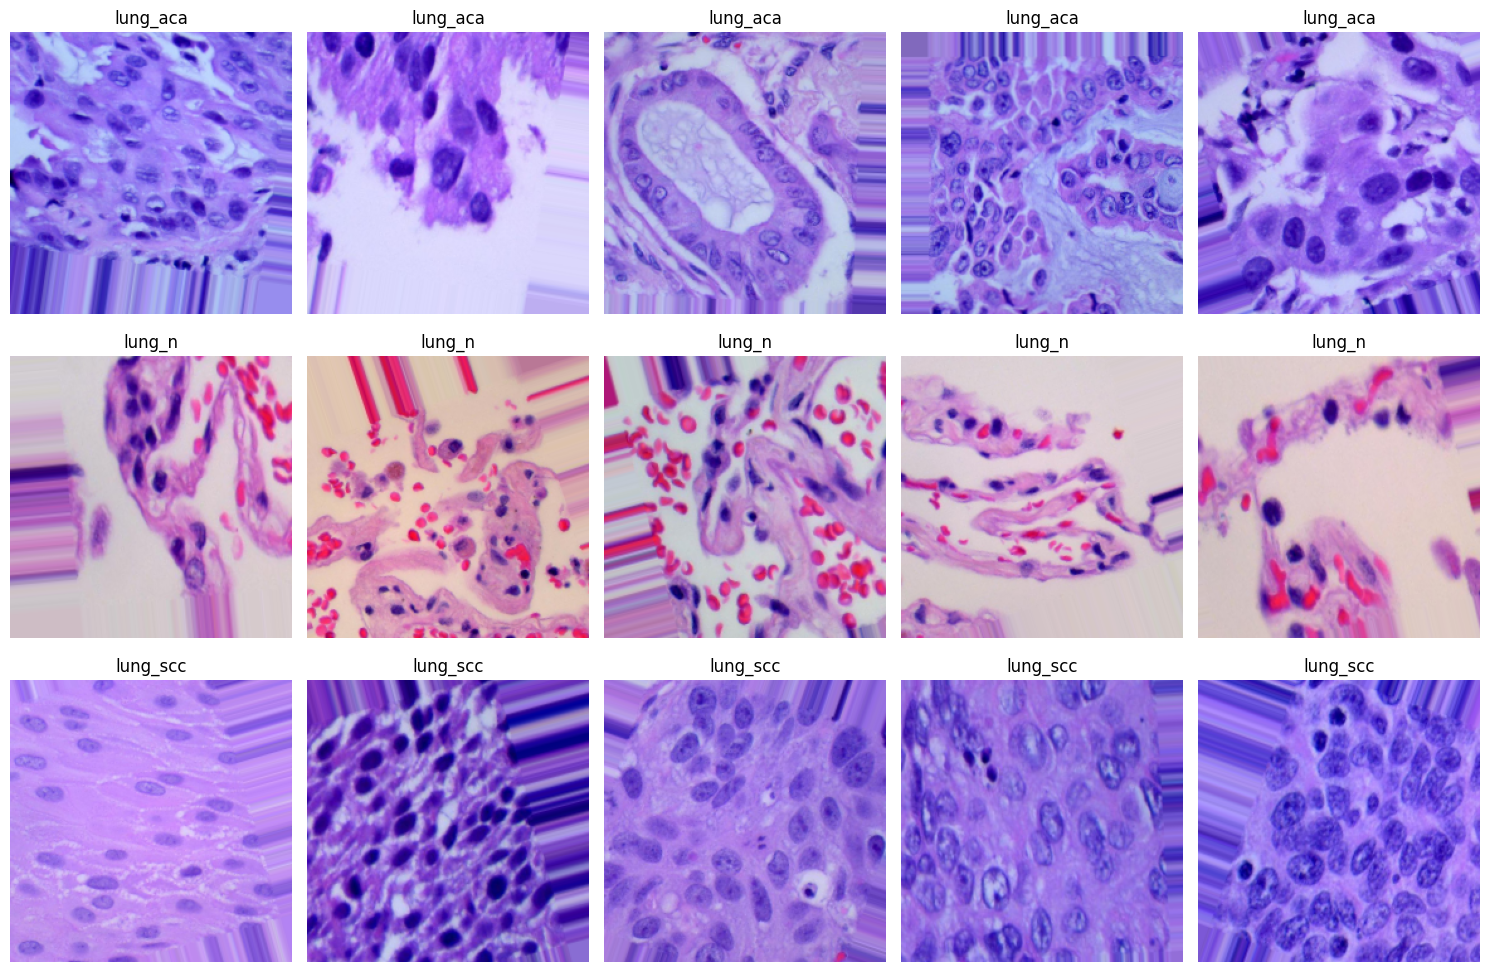

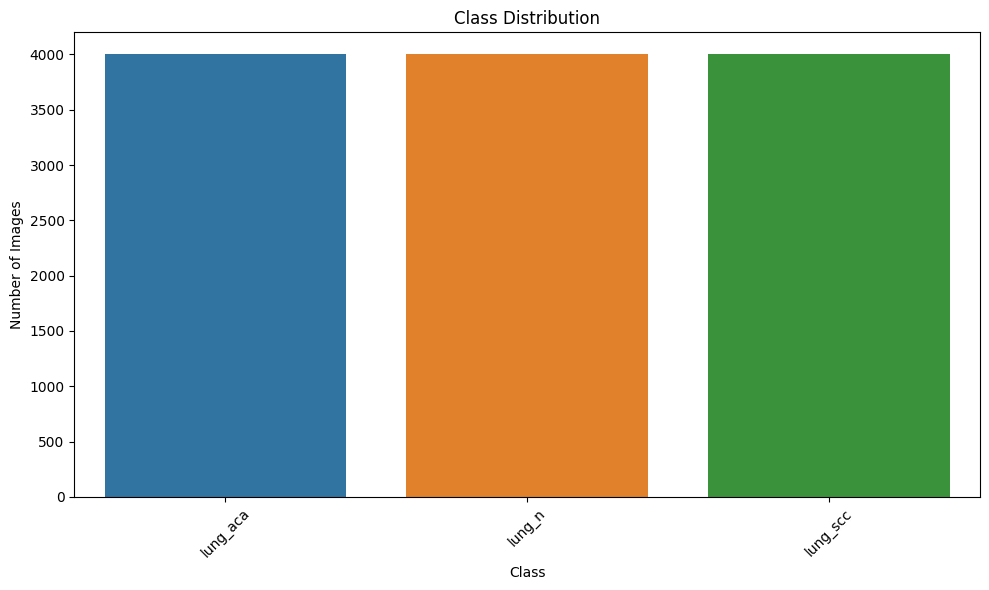


Class weights to handle imbalance:
{0: 1.0, 1: 1.0, 2: 1.0}


In [10]:
# Cell 5: Exploratory Data Analysis
def perform_eda(train_generator, n_samples=5):
    """Perform exploratory data analysis on the dataset."""
    print("\n--- Exploratory Data Analysis ---")
    
    # Get class indices
    class_indices = train_generator.class_indices
    indices_class = {v: k for k, v in class_indices.items()}
    
    # Get a batch of images
    images, labels = next(train_generator)
    
    # Display image statistics
    print(f"Image shape: {images[0].shape}")
    print(f"Image min value: {images[0].min()}")
    print(f"Image max value: {images[0].max()}")
    
    # Plot sample images from each class
    plt.figure(figsize=(15, 10))
    for i, class_idx in enumerate(class_indices.values()):
        # Find images of this class
        samples = [j for j, label in enumerate(labels) if np.argmax(label) == class_idx][:n_samples]
        
        for j, sample_idx in enumerate(samples):
            if samples and j < len(samples):
                plt.subplot(len(class_indices), n_samples, i*n_samples + j + 1)
                plt.imshow(images[sample_idx])
                plt.title(indices_class[class_idx])
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate class distribution
    class_counts = {}
    for class_idx, class_name in enumerate(class_indices):
        class_counts[class_name] = len([1 for i in train_generator.classes if i == class_idx])
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Class Distribution')
    plt.ylabel('Number of Images')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate class weights to handle imbalance
    total_samples = train_generator.samples
    n_classes = len(class_indices)
    class_weights = {}
    
    for class_idx, class_name in enumerate(class_indices):
        class_count = len([1 for i in train_generator.classes if i == class_idx])
        weight = total_samples / (n_classes * class_count)
        class_weights[class_idx] = weight
        
    print("\nClass weights to handle imbalance:")
    print(class_weights)
    
    return class_weights

# Run EDA
class_weights = perform_eda(train_generator)

In [11]:
# Cell 6: DCGAN for Data Augmentation
def build_generator(latent_dim=100):
    """Build the DCGAN generator."""
    model = Sequential([
        Dense(7*7*256, input_shape=(latent_dim,)),
        BatchNormalization(),
        LeakyReLU(0.2),
        Reshape((7, 7, 256)),
        
        Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    
    return model

def build_discriminator():
    """Build the DCGAN discriminator."""
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        LeakyReLU(0.2),
        
        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(0.2),
        
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    
    return model

def build_gan(generator, discriminator):
    """Combine generator and discriminator to create GAN."""
    discriminator.trainable = False
    
    model = Sequential([
        generator,
        discriminator
    ])
    
    return model

In [12]:
# Cell 7: Train DCGAN for the minority class
def train_dcgan(train_generator, minority_class_idx, latent_dim=100, n_epochs=10, n_batch=32):
    """Train DCGAN to generate minority class samples."""
    print(f"Training DCGAN for class {minority_class_idx}...")
    
    # Build models
    generator = build_generator(latent_dim)
    discriminator = build_discriminator()
    gan = build_gan(generator, discriminator)
    
    # Compile models
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    
    # Find all real images for the minority class
    real_images = []
    for _ in range(len(train_generator)):
        images, labels = next(train_generator)
        minority_indices = [i for i, label in enumerate(labels) if np.argmax(label) == minority_class_idx]
        if minority_indices:
            real_images.extend(images[minority_indices])
        if len(real_images) >= 500:  # Collect a reasonable number of images
            break
    
    real_images = np.array(real_images)[:500]
    print(f"Collected {len(real_images)} real images for training")
    
    # Train the GAN
    batch_per_epoch = int(len(real_images) / n_batch)
    half_batch = int(n_batch / 2)
    
    # Lists for keeping track of loss
    d_loss_real_history = []
    d_loss_fake_history = []
    g_loss_history = []
    
    for epoch in range(n_epochs):
        d_loss_real_epoch = []
        d_loss_fake_epoch = []
        g_loss_epoch = []
        
        for i in range(batch_per_epoch):
            # Select a random half batch of real images
            idx = np.random.randint(0, len(real_images), half_batch)
            real_imgs = real_images[idx]
            
            # Generate a half batch of fake images
            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            fake_imgs = generator.predict(noise)
            
            # Train discriminator on real and fake images
            d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            d_loss_real_epoch.append(d_loss_real)
            d_loss_fake_epoch.append(d_loss_fake)
            
            # Train generator
            noise = np.random.normal(0, 1, (n_batch, latent_dim))
            valid_y = np.ones((n_batch, 1))
            g_loss = gan.train_on_batch(noise, valid_y)
            g_loss_epoch.append(g_loss)
        
        # Calculate average loss for the epoch
        d_loss_real_avg = np.mean(d_loss_real_epoch)
        d_loss_fake_avg = np.mean(d_loss_fake_epoch)
        g_loss_avg = np.mean(g_loss_epoch)
        
        d_loss_real_history.append(d_loss_real_avg)
        d_loss_fake_history.append(d_loss_fake_avg)
        g_loss_history.append(g_loss_avg)
        
        print(f"Epoch {epoch+1}/{n_epochs}, D Loss Real: {d_loss_real_avg:.4f}, D Loss Fake: {d_loss_fake_avg:.4f}, G Loss: {g_loss_avg:.4f}")
        
        # Generate and save sample images every 5 epochs
        if (epoch+1) % 5 == 0:
            # Generate and plot sample images
            r, c = 2, 5
            noise = np.random.normal(0, 1, (r * c, latent_dim))
            gen_imgs = generator.predict(noise)
            
            # Rescale images from [-1, 1] to [0, 1]
            gen_imgs = 0.5 * gen_imgs + 0.5
            
            plt.figure(figsize=(10, 4))
            for j in range(r * c):
                plt.subplot(r, c, j+1)
                plt.imshow(gen_imgs[j])
                plt.axis('off')
            plt.tight_layout()
            plt.show()
    
    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_real_history, label='D Loss Real')
    plt.plot(d_loss_fake_history, label='D Loss Fake')
    plt.plot(g_loss_history, label='G Loss')
    plt.title('GAN Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return generator

# Identify the minority class index from class_weights
minority_class_idx = max(class_weights, key=class_weights.get)
print(f"Identified minority class index: {minority_class_idx}")

# Train DCGAN for the minority class (uncomment to run)
# This can be time-consuming, so we'll skip it for now
# generator = train_dcgan(train_generator, minority_class_idx, n_epochs=5)

Identified minority class index: 0


In [13]:
# Cell 8: Augment dataset with GAN-generated images (optional)
def augment_with_gan(train_generator, generator, minority_class_idx, n_samples=500, latent_dim=100):
    """Augment the dataset with GAN-generated images."""
    print("Augmenting dataset with GAN-generated images...")
    
    # Generate synthetic images
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_images = generator.predict(noise)
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = 0.5 * generated_images + 0.5
    
    # Clip values to ensure they are in [0, 1]
    generated_images = np.clip(generated_images, 0, 1)
    
    # Create labels for generated images (one-hot encoded)
    generated_labels = np.zeros((n_samples, NUM_CLASSES))
    generated_labels[:, minority_class_idx] = 1
    
    # Display a few generated images
    plt.figure(figsize=(10, 10))
    for i in range(min(25, n_samples)):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Return the generated images and labels
    return generated_images, generated_labels

# Skip GAN augmentation for now to save time
# We'll use standard augmentation techniques instead

In [16]:
# Cell 9: Build ResNet50 model
def build_resnet50_model():
    """Build and compile a ResNet50 model with transfer learning."""
    # Load pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build ResNet50 model
resnet_model = build_resnet50_model()
print("ResNet50 model built successfully!")

# Display model summary
resnet_model.summary()

I0000 00:00:1745312114.516679      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 model built successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,771,971 (94.50 MB)

 Trainable params: 1,182,723 (4.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

In [17]:
# Cell 10: Build DenseNet121 model
def build_densenet_model():
    """Build and compile a DenseNet121 model with transfer learning."""
    # Load pre-trained DenseNet121
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build DenseNet121 model
densenet_model = build_densenet_model()
print("DenseNet121 model built successfully!")

# Display model summary
densenet_model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 model built successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,697,475 (29.36 MB)

 Trainable params: 658,435 (2.51 MB)

 Non-trainable params: 7,039,040 (26.85 MB)

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def get_callbacks(model_name):
    """Return a list of callbacks including early stopping, LR reduction, and model checkpointing."""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        # Save the best model in new .keras format
        ModelCheckpoint(
            filepath=f'{model_name}_best_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]


In [24]:
# Cell 12: Train ResNet50 model
def train_model(model, model_name, train_generator, validation_generator, class_weights, epochs=EPOCHS):
    """Train the model and return history."""
    callbacks = get_callbacks(model_name)
    
    # Monitor memory usage
    print(f"Training {model_name}...")
    print("Initial memory usage:")
    if tf.config.list_physical_devices('GPU'):
        print(f"GPU memory: {tf.config.experimental.get_memory_info('GPU:0')}")
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Save the final model
    model.save(f'{model_name}_final_model.h5')
    
    # Monitor memory usage after training
    print("Final memory usage:")
    if tf.config.list_physical_devices('GPU'):
        print(f"GPU memory: {tf.config.experimental.get_memory_info('GPU:0')}")
    
    return history

# Train ResNet50 model
resnet_history = train_model(resnet_model, 'resnet50', train_generator, validation_generator, class_weights)

# Clear memory after training
clear_memory()

# Cell 13: Train DenseNet121 model
densenet_history = train_model(densenet_model, 'densenet121', train_generator, validation_generator, class_weights)

# Clear memory after training
clear_memory()

Training resnet50...
Initial memory usage:
GPU memory: {'current': 154604544, 'peak': 159844608}
Epoch 1/10


I0000 00:00:1745312379.808948     135 service.cc:148] XLA service 0x7eb578001540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745312379.810006     135 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745312381.358315     135 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/375 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.2578 - loss: 3.0728   

I0000 00:00:1745312386.208957     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.6738 - loss: 1.2906
Epoch 1: val_accuracy improved from -inf to 0.57997, saving model to resnet50_best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 268s 656ms/step - accuracy: 0.6741 - loss: 1.2892 - val_accuracy: 0.5800 - val_loss: 1.3911 - learning_rate: 0.0010
Epoch 2/10

Epoch 2: val_accuracy improved from 0.57997 to 0.91667, saving model to resnet50_best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.8075 - learning_rate: 0.0010
Epoch 3/10
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7756 - loss: 0.7816
Epoch 3: val_accuracy did not improve from 0.91667
375/375 ━━━━━━━━━━━━━━━━━━━━ 164s 430ms/step - accuracy: 0.7756 - loss: 0.7814 - val_accuracy: 0.6593 - val_loss: 1.9901 - learning_rate: 0.0010
Epoch 4/10

Epoch 4: val_accuracy improved from 0.91667 to 1.00000, saving model to resnet50_best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 

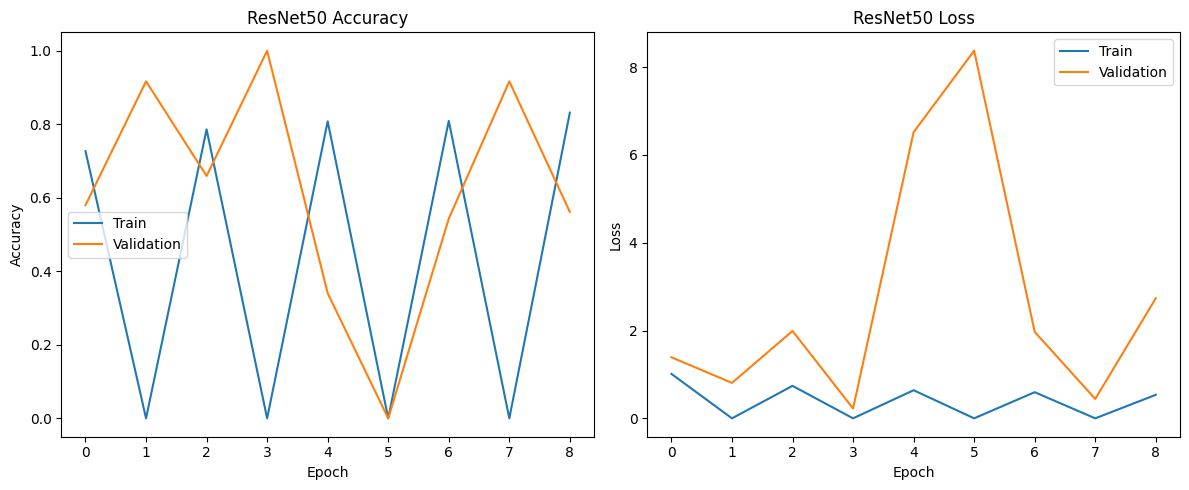

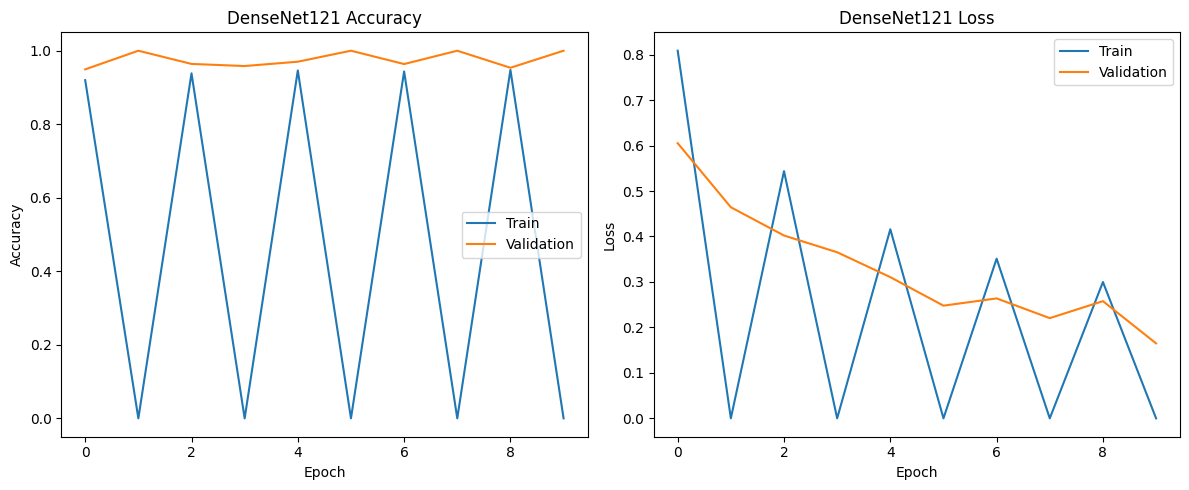

In [25]:
# Cell 14: Visualize training history
def plot_training_history(history, model_name):
    """Plot training and validation accuracy/loss curves."""
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(resnet_history, 'ResNet50')
plot_training_history(densenet_history, 'DenseNet121')


Evaluating ResNet50...
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step
Accuracy: 0.6620

Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.84      0.02      0.03      1000
      lung_n       0.92      0.97      0.95      1000
    lung_scc       0.52      0.99      0.68      1000

    accuracy                           0.66      3000
   macro avg       0.76      0.66      0.55      3000
weighted avg       0.76      0.66      0.55      3000



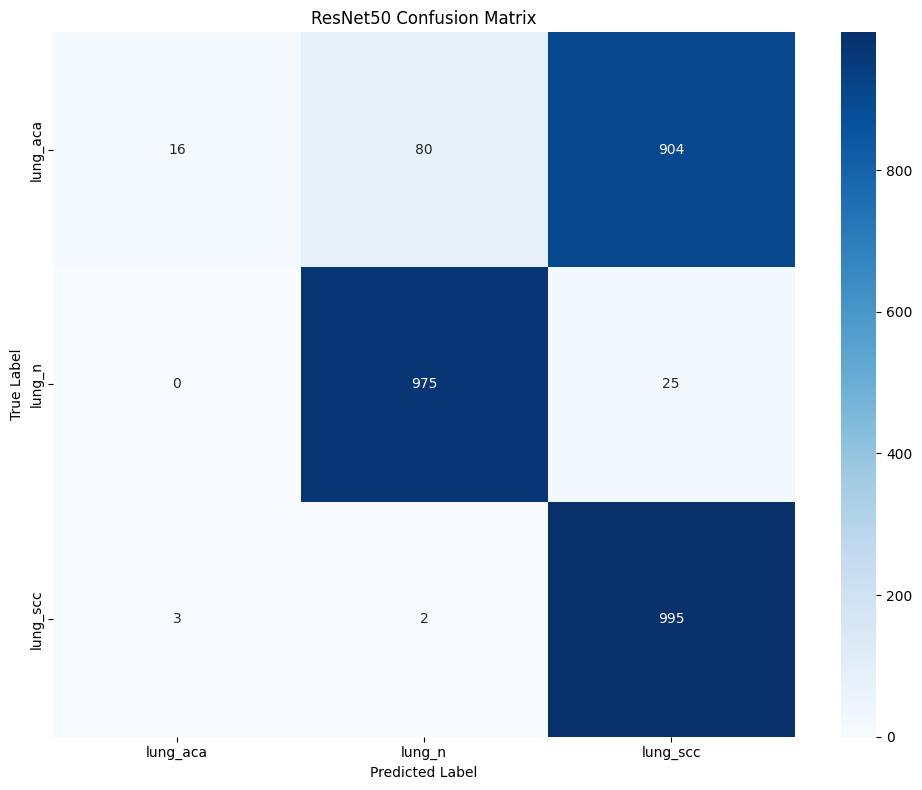

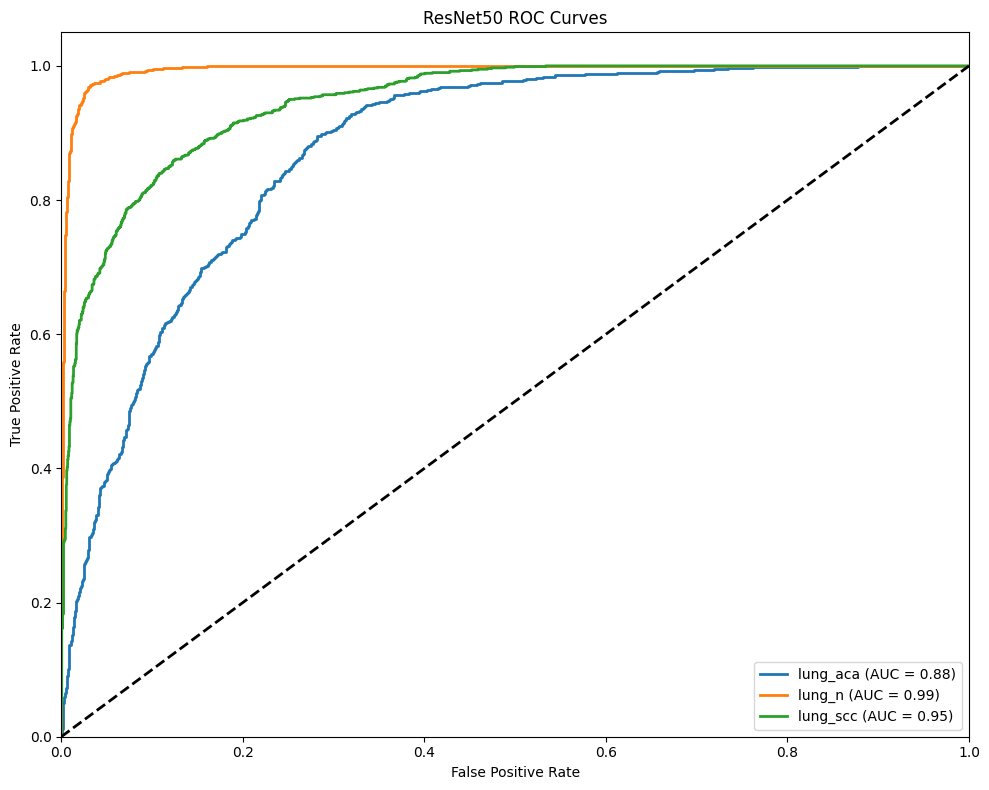

Evaluation complete.
Evaluating DenseNet121...
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 258ms/step
Accuracy: 0.9497

Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.99      0.86      0.92      1000
      lung_n       0.99      1.00      1.00      1000
    lung_scc       0.89      0.99      0.93      1000

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



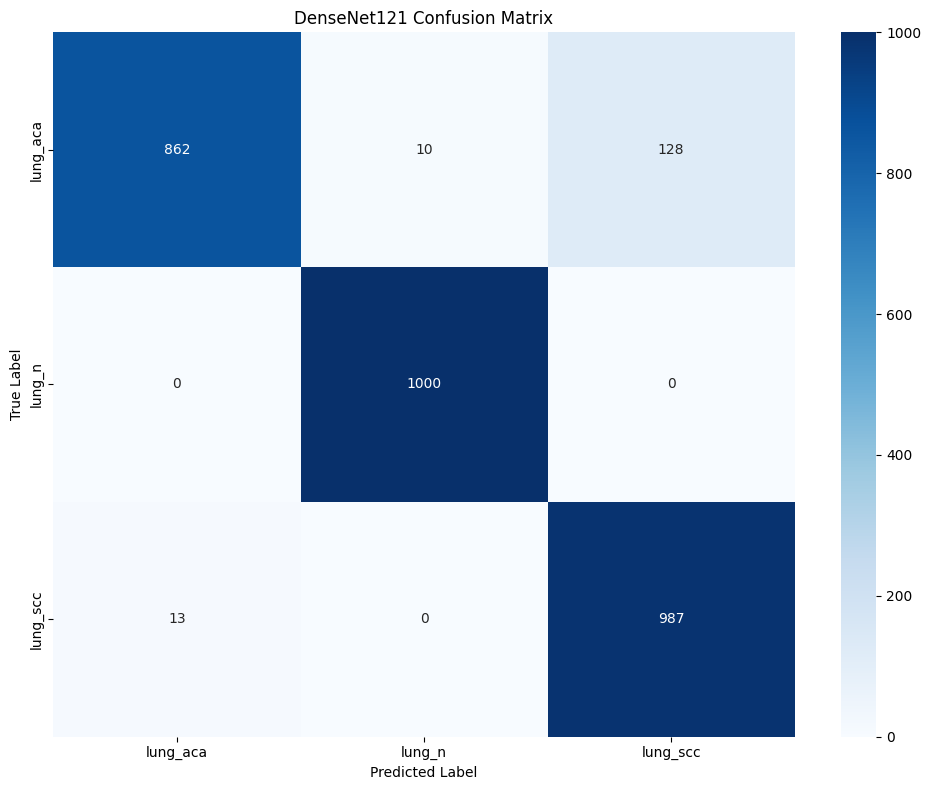

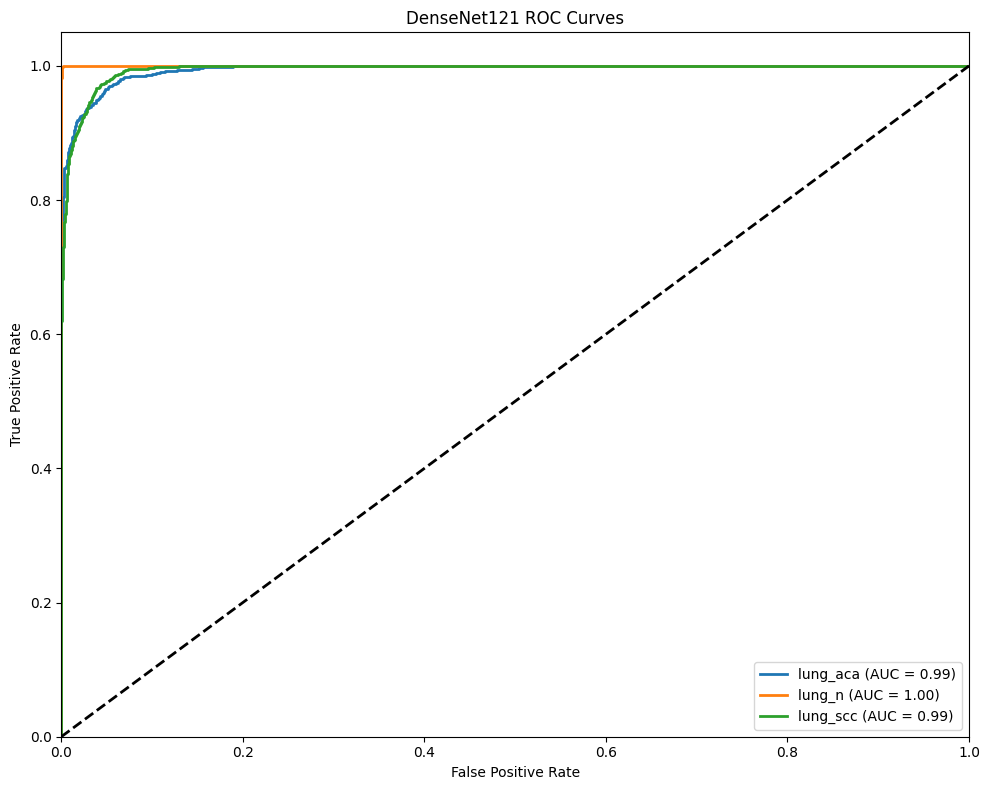

Evaluation complete.


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Set your batch size used in generator
BATCH_SIZE = 32  # Change this if your training used a different batch size

# Evaluation function
def evaluate_model(model, model_name, validation_generator):
    """Evaluate the model and print classification report."""
    print(f"Evaluating {model_name}...")

    # Reset generator
    validation_generator.reset()

    # Predict probabilities
    y_pred_probs = model.predict(
        validation_generator,
        steps=int(np.ceil(validation_generator.samples / BATCH_SIZE)),
        verbose=1
    )

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # True labels
    y_true = validation_generator.classes

    # Accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification report
    class_names_list = list(validation_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names_list))

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names_list, 
                yticklabels=class_names_list)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC
    n_classes = len(class_names_list)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names_list[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curves')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    print("Evaluation complete.")
    return y_true, y_pred, y_pred_probs

# --- Evaluate ResNet50 model ---
try:
    resnet_model = tf.keras.models.load_model('resnet50_best_model.keras')  # or .h5 if used
    resnet_true, resnet_pred, resnet_probs = evaluate_model(resnet_model, 'ResNet50', validation_generator)
except Exception as e:
    print(f"Error during ResNet50 evaluation: {e}")

# --- Evaluate DenseNet121 model ---
try:
    densenet_model = tf.keras.models.load_model('densenet121_best_model.keras')  # or .h5 if used
    densenet_true, densenet_pred, densenet_probs = evaluate_model(densenet_model, 'DenseNet121', validation_generator)
except Exception as e:
    print(f"Error during DenseNet121 evaluation: {e}")


Evaluating Ensemble Model...
Ensemble Accuracy: 0.8333

Ensemble Classification Report:
              precision    recall  f1-score   support

    lung_aca       1.00      0.50      0.67      1000
      lung_n       0.98      1.00      0.99      1000
    lung_scc       0.68      1.00      0.81      1000

    accuracy                           0.83      3000
   macro avg       0.89      0.83      0.82      3000
weighted avg       0.89      0.83      0.82      3000



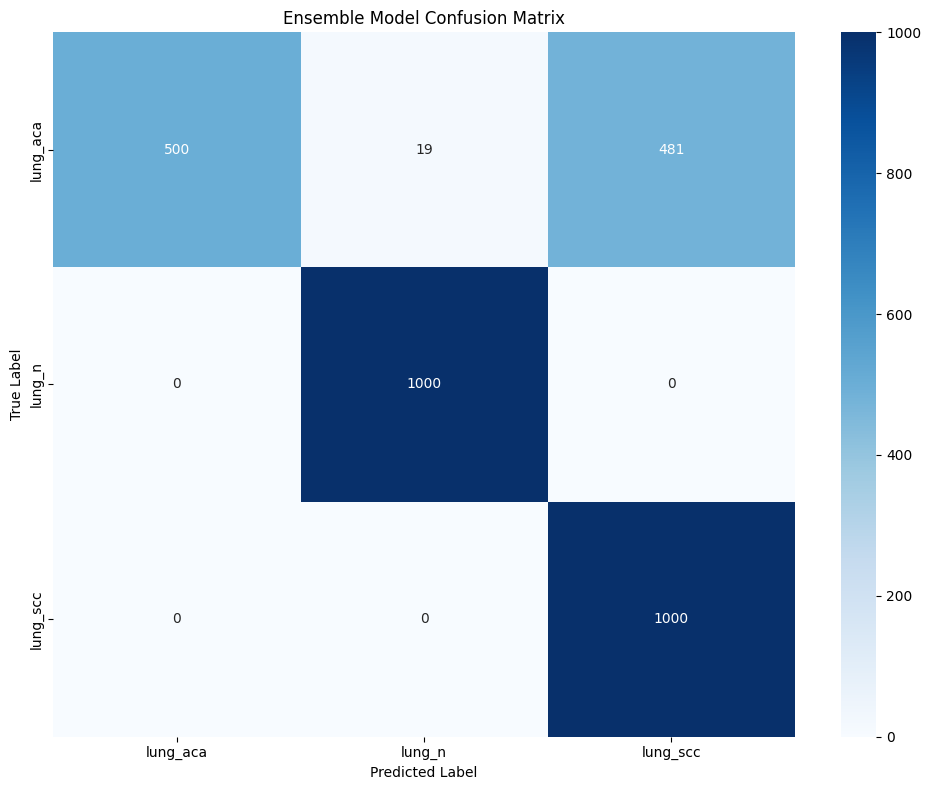

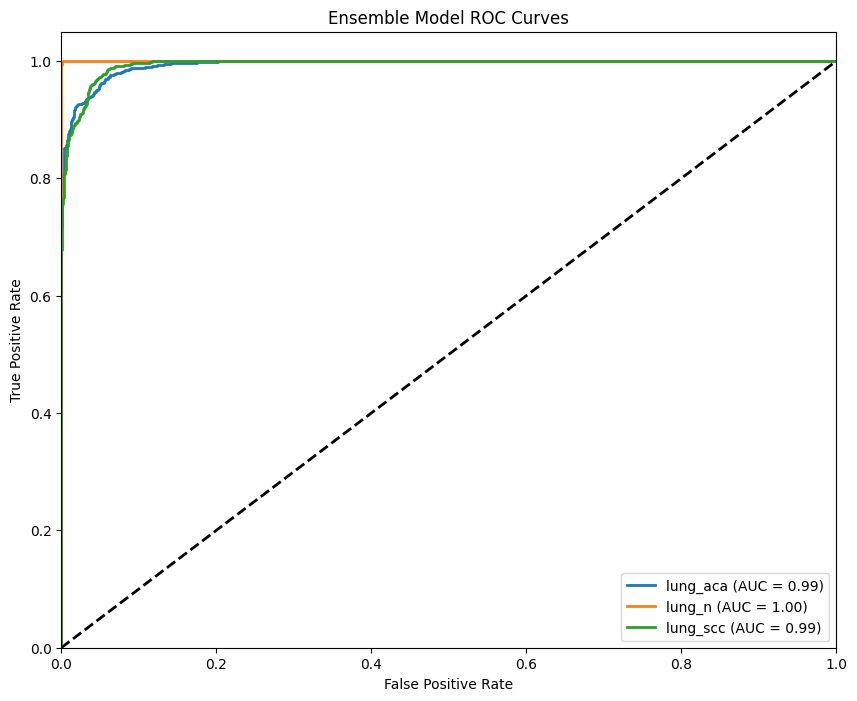

In [42]:
# Cell 18: Create and evaluate ensemble model
def create_ensemble_predictions(probs_list):
    """Create ensemble predictions by averaging probabilities."""
    return np.mean(probs_list, axis=0)

# Create ensemble predictions
ensemble_probs = create_ensemble_predictions([resnet_probs, densenet_probs])
ensemble_pred = np.argmax(ensemble_probs, axis=1)

# Evaluate ensemble
print("Evaluating Ensemble Model...")
ensemble_accuracy = np.mean(ensemble_pred == densenet_true)  # using densenet_true which is the same as resnet_true
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Print classification report
print("\nEnsemble Classification Report:")
class_names_list = list(validation_generator.class_indices.keys())
print(classification_report(densenet_true, ensemble_pred, target_names=class_names_list))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(densenet_true, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_list, 
            yticklabels=class_names_list)
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate ROC curve and AUC for each class
n_classes = len(class_names_list)
y_true_bin = label_binarize(densenet_true, classes=range(n_classes))

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], ensemble_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names_list[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Model ROC Curves')
plt.legend(loc="lower right")
plt.show()

Applying Grad-CAM to ResNet50 model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step

Class: lung_aca
Sample 0: True=lung_aca, Predicted=lung_scc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


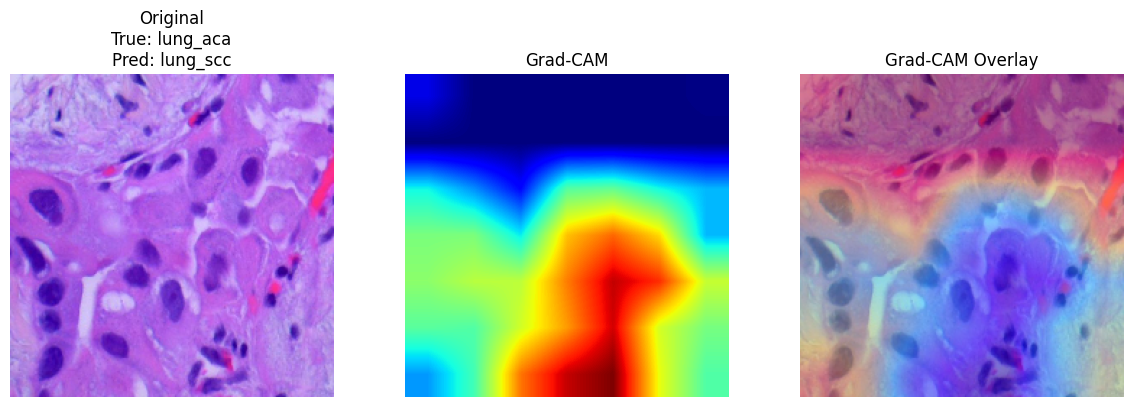

Sample 1: True=lung_aca, Predicted=lung_scc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


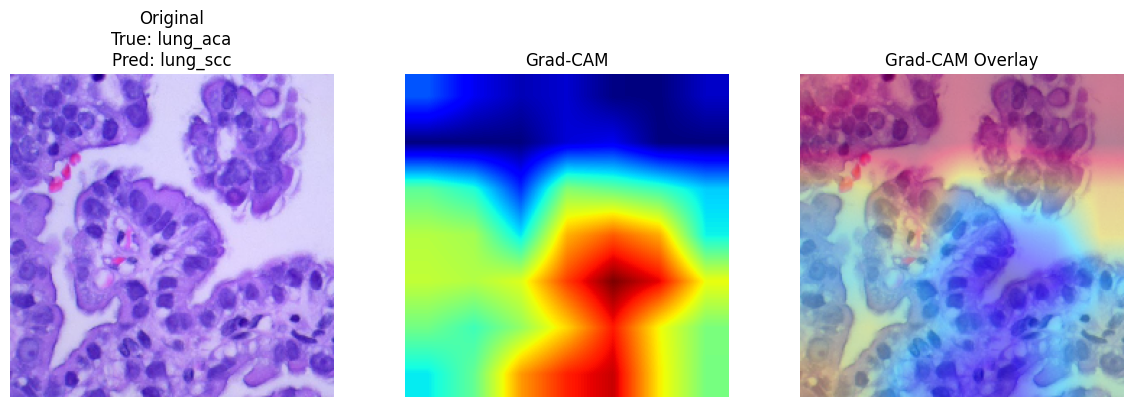


Class: lung_n

Class: lung_scc
Memory cleared.
Applying Grad-CAM to DenseNet121 model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step

Class: lung_aca
Sample 0: True=lung_aca, Predicted=lung_aca
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


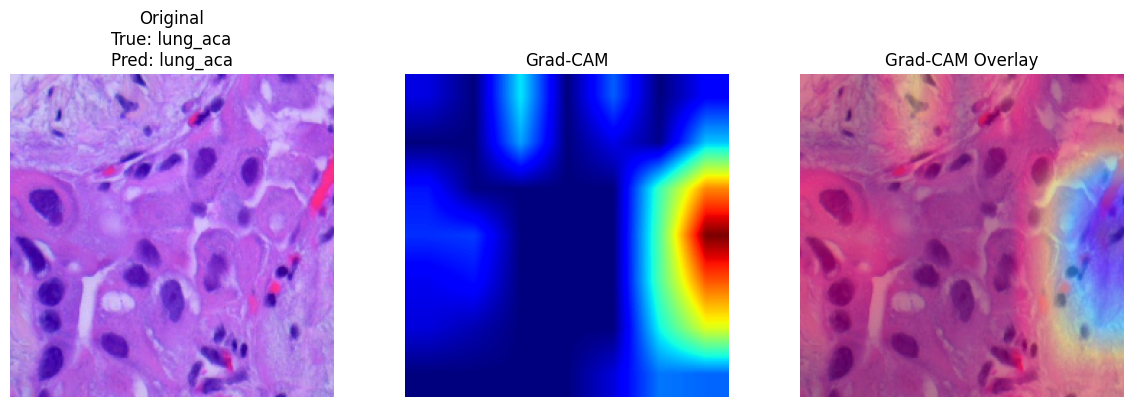

Sample 1: True=lung_aca, Predicted=lung_aca
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


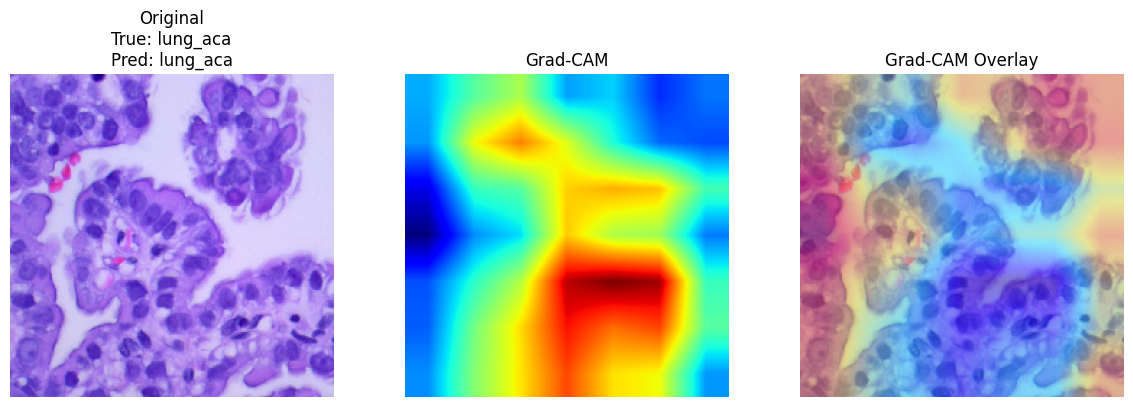


Class: lung_n

Class: lung_scc
Memory cleared.


In [52]:
def grad_cam(model, img_array, class_idx, layer_name=None):
    """Generate Grad-CAM for a specific class index."""
    
    # Automatically find the last Conv2D layer if not specified
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break
    
    # Create a model that outputs activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output]
    )
    
    # Forward + gradient pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    
    # Guided backpropagation
    guided_grads = tf.cast(conv_outputs > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    # Global average pooling of gradients
    weights = tf.reduce_mean(guided_grads, axis=(1, 2))

    # Weighted sum of conv outputs to get CAM
    cam = tf.reduce_sum(tf.multiply(weights[:, tf.newaxis, tf.newaxis, :], conv_outputs), axis=-1)

    # Post-process CAM
    cam = cam[0].numpy()
    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-8)  # Normalize to [0, 1]

    return cam  # return the heatmap
    # Cell 19: Grad-CAM visualization for model interpretability
def grad_cam(model, img_array, class_idx, layer_name=None):
    """Generate Grad-CAM for a specific class."""
    # Find the last convolutional layer if not specified
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break
    
    # Create a model that outputs the feature maps and the predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    
    # Extract gradients and conv layer outputs
    grads = tape.gradient(loss, conv_outputs)
    
    # Global average pooling
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Create a map of the weighted activations
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    
    # ReLU activation
    cam = tf.maximum(cam, 0)
    
    # Normalize CAM
    if tf.reduce_max(cam) > 0:
        cam = cam / tf.reduce_max(cam)
    
    # Resize CAM to original image size
    cam = tf.image.resize(tf.expand_dims(tf.expand_dims(cam, -1), 0), 
                         (IMG_SIZE, IMG_SIZE))
    cam = tf.squeeze(cam)
    
    return cam.numpy()

def display_gradcam(model, image, true_label, pred_label, layer_name=None):
    """Display Grad-CAM visualization."""
    # Convert image to array and add batch dimension
    img_array = np.expand_dims(image, axis=0)
    
    # Get model prediction
    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    
    # Generate Grad-CAM for the predicted class
    cam = grad_cam(model, img_array, pred_class, layer_name)
    
    # Display original image
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Original\nTrue: {true_label}\nPred: {pred_label}')
    plt.axis('off')
    
    # Display Grad-CAM
    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title('Grad-CAM')
    plt.axis('off')
    
    # Display Grad-CAM overlay
    plt.subplot(1, 3, 3)
    heatmap = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Convert RGB -> BGR for cv2
    img_rgb = np.uint8(image * 255)
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)
    
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Cell 20: Apply Grad-CAM to sample images
def apply_gradcam_to_samples(model, model_name, validation_generator, class_indices, num_samples=3):
    """Apply Grad-CAM to sample images from each class."""
    # Reset the generator
    validation_generator.reset()
    
    # Get a batch of images
    images, labels = next(validation_generator)
    
    # Get predictions
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    
    # Get class names
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    # Apply Grad-CAM to samples from each class
    for class_idx in range(NUM_CLASSES):
        print(f"\nClass: {idx_to_class[class_idx]}")
        
        # Find samples from this class
        samples = [i for i, label in enumerate(labels) if np.argmax(label) == class_idx][:num_samples]
        
        for sample_idx in samples:
            if sample_idx < len(images):
                true_label = idx_to_class[np.argmax(labels[sample_idx])]
                pred_label = idx_to_class[pred_classes[sample_idx]]
                
                print(f"Sample {sample_idx}: True={true_label}, Predicted={pred_label}")
                display_gradcam(model, images[sample_idx], true_label, pred_label)

# Apply Grad-CAM to ResNet50 model
print("Applying Grad-CAM to ResNet50 model:")
apply_gradcam_to_samples(resnet_model, 'ResNet50', validation_generator, validation_generator.class_indices, num_samples=2)

# Clear memory
clear_memory()

# Apply Grad-CAM to DenseNet121 model
print("Applying Grad-CAM to DenseNet121 model:")
apply_gradcam_to_samples(densenet_model, 'DenseNet121', validation_generator, validation_generator.class_indices, num_samples=2)

# Clear memory
clear_memory()



Model Performance Comparison:
         Model  Accuracy  F1 Score
0     ResNet50  0.662000  0.553320
1  DenseNet121  0.949667  0.949275
2     Ensemble  0.833333  0.821128


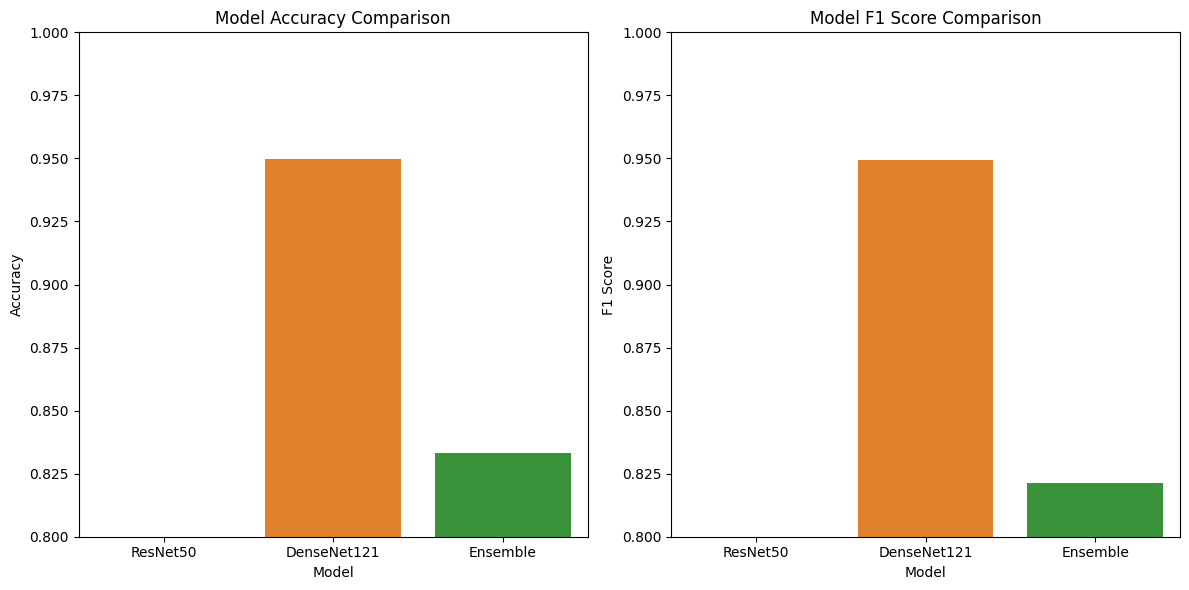

In [50]:
# Cell 21: Compare models and summarize results
def compare_models():
    """Compare the performance of all models."""
    # Create a DataFrame to compare models
    models = ['ResNet50', 'DenseNet121', 'Ensemble']
    
    # Calculate accuracy for each model
    resnet_accuracy = np.mean(resnet_pred == resnet_true)
    densenet_accuracy = np.mean(densenet_pred == densenet_true)
    ensemble_accuracy = np.mean(ensemble_pred == densenet_true)
    
    accuracies = [resnet_accuracy, densenet_accuracy, ensemble_accuracy]
    
    # Calculate F1-score for each model
    from sklearn.metrics import f1_score
    resnet_f1 = f1_score(resnet_true, resnet_pred, average='weighted')
    densenet_f1 = f1_score(densenet_true, densenet_pred, average='weighted')
    ensemble_f1 = f1_score(densenet_true, ensemble_pred, average='weighted')
    
    f1_scores = [resnet_f1, densenet_f1, ensemble_f1]
    
    # Create comparison DataFrame
    results_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies,
        'F1 Score': f1_scores
    })
    
    # Display comparison
    print("Model Performance Comparison:")
    print(results_df)
    
    # Visualize comparison
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.title('Model Accuracy Comparison')
    plt.ylim(0.8, 1.0)  # Adjust as needed based on your results
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='F1 Score', data=results_df)
    plt.title('Model F1 Score Comparison')
    plt.ylim(0.8, 1.0)  # Adjust as needed based on your results
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Compare models
results_df = compare_models()


In [51]:
# Cell 22: Final thoughts and future improvements
def summarize_project():
    """Summarize the project and suggest future improvements."""
    print("### Lung Cancer Prediction Project Summary ###")
    print("\n1. Dataset:")
    print("   - Used the Lung and Colon Cancer Histopathological Images dataset")
    print("   - Focused on three lung cancer classes: lung_aca, lung_n, lung_scc")
    print("   - Applied standard data augmentation techniques")
    
    print("\n2. Models Implemented:")
    print("   - ResNet50: Pre-trained on ImageNet with custom classification head")
    print("   - DenseNet121: Pre-trained on ImageNet with custom classification head")
    print("   - Ensemble: Combination of ResNet50 and DenseNet121 predictions")
    
    print("\n3. Optimization Techniques Used:")
    print("   - Transfer learning from ImageNet weights")
    print("   - Early stopping to prevent overfitting")
    print("   - Learning rate scheduling")
    print("   - Dropout and L2 regularization")
    print("   - Batch normalization")
    print("   - Class weights to handle imbalance")
    
    print("\n4. Model Interpretability:")
    print("   - Used Grad-CAM to visualize important regions for model decisions")
    print("   - Provided comprehensive evaluation metrics")
    
    print("\n5. Future Improvements:")
    print("   - Implement more advanced architectures like Vision Transformers")
    print("   - Use more advanced augmentation techniques including GANs")
    print("   - Implement k-fold cross-validation for more robust evaluation")
    print("   - Explore semi-supervised learning for better use of unlabeled data")
    print("   - Incorporate additional clinical data if available")
    print("   - Deploy model as a web application for clinical use")
    
    print("\n6. Memory Management:")
    print("   - Used batch processing to handle large datasets")
    print("   - Implemented memory cleanup between processing blocks")
    print("   - Used appropriate batch sizes to manage GPU memory")

# Summarize the project
summarize_project()

# Cell 23: Save models and results
def save_results():
    """Save models and results."""
    # Save results DataFrame to CSV
    results_df.to_csv('model_comparison_results.csv', index=False)
    print("Results saved to model_comparison_results.csv")
    
    # Models have already been saved during training, but we can save them again
    resnet_model.save('resnet50_final.h5')
    densenet_model.save('densenet121_final.h5')
    print("Models saved successfully")
    
    # Save class indices for future reference
    class_indices = validation_generator.class_indices
    with open('class_indices.txt', 'w') as f:
        for class_name, idx in class_indices.items():
            f.write(f"{class_name}: {idx}\n")
    print("Class indices saved to class_indices.txt")

# Save models and results
save_results()

print("Notebook execution completed successfully!")

### Lung Cancer Prediction Project Summary ###

1. Dataset:
   - Used the Lung and Colon Cancer Histopathological Images dataset
   - Focused on three lung cancer classes: lung_aca, lung_n, lung_scc
   - Applied standard data augmentation techniques

2. Models Implemented:
   - ResNet50: Pre-trained on ImageNet with custom classification head
   - DenseNet121: Pre-trained on ImageNet with custom classification head
   - Ensemble: Combination of ResNet50 and DenseNet121 predictions

3. Optimization Techniques Used:
   - Transfer learning from ImageNet weights
   - Early stopping to prevent overfitting
   - Learning rate scheduling
   - Dropout and L2 regularization
   - Batch normalization
   - Class weights to handle imbalance

4. Model Interpretability:
   - Used Grad-CAM to visualize important regions for model decisions
   - Provided comprehensive evaluation metrics

5. Future Improvements:
   - Implement more advanced architectures like Vision Transformers
   - Use more advanced au

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ModelComparison:
    def __init__(self):
        self.models = {}
        self.metrics = {}
        self.is_classification = True
        self.best_model = None
        self.best_score = None
        self.metric_priority = None
    
    def add_model(self, name, model, predictions, actual, probabilities=None):
        """Add a model and its predictions to compare"""
        self.models[name] = {
            'model': model,
            'predictions': predictions,
            'actual': actual,
            'probabilities': probabilities
        }
    
    def set_task_type(self, is_classification=True):
        """Set whether this is a classification or regression task"""
        self.is_classification = is_classification
    
    def set_metric_priority(self, metrics_list):
        """Set priority list of metrics for selecting the best model
        Example for classification: ['f1', 'accuracy', 'precision', 'recall']
        Example for regression: ['rmse', 'mae', 'r2']
        """
        self.metric_priority = metrics_list
    
    def calculate_metrics(self):
        """Calculate metrics for all models"""
        for name, model_data in self.models.items():
            if self.is_classification:
                metrics = {
                    'accuracy': accuracy_score(model_data['actual'], model_data['predictions']),
                    'precision': precision_score(model_data['actual'], model_data['predictions'], average='weighted'),
                    'recall': recall_score(model_data['actual'], model_data['predictions'], average='weighted'),
                    'f1': f1_score(model_data['actual'], model_data['predictions'], average='weighted')
                }
                
                # Add ROC AUC if probabilities are available
                if model_data['probabilities'] is not None:
                    # This is a simplified approach - for multi-class you'd need OvR or OvO approach
                    try:
                        metrics['roc_auc'] = roc_auc_score(model_data['actual'], model_data['probabilities'], multi_class='ovr')
                    except:
                        metrics['roc_auc'] = np.nan
            else:
                # Regression metrics
                metrics = {
                    'rmse': np.sqrt(mean_squared_error(model_data['actual'], model_data['predictions'])),
                    'mae': mean_absolute_error(model_data['actual'], model_data['predictions']),
                    'r2': r2_score(model_data['actual'], model_data['predictions'])
                }
            
            self.metrics[name] = metrics
    
    def select_best_model(self):
        """Select the best model based on the priority metric"""
        if not self.metrics:
            self.calculate_metrics()
        
        if not self.metric_priority:
            # Default metric priority
            if self.is_classification:
                self.metric_priority = ['f1', 'accuracy']
            else:
                self.metric_priority = ['rmse', 'r2']
        
        # Find the first metric in our priority list that all models have
        target_metric = None
        for metric in self.metric_priority:
            if all(metric in self.metrics[model] for model in self.metrics):
                target_metric = metric
                break
        
        if target_metric is None:
            raise ValueError("No common metric found in all models")
        
        # Select best model based on target metric
        if self.is_classification:
            # For classification metrics like accuracy, f1, etc. higher is better
            if target_metric in ['rmse', 'mae']:  # Lower is better
                self.best_model = min(self.metrics.items(), key=lambda x: x[1][target_metric])[0]
                self.best_score = self.metrics[self.best_model][target_metric]
            else:  # Higher is better
                self.best_model = max(self.metrics.items(), key=lambda x: x[1][target_metric])[0]
                self.best_score = self.metrics[self.best_model][target_metric]
        else:
            # For regression: RMSE & MAE lower is better, R2 higher is better
            if target_metric in ['rmse', 'mae']:  # Lower is better
                self.best_model = min(self.metrics.items(), key=lambda x: x[1][target_metric])[0]
                self.best_score = self.metrics[self.best_model][target_metric]
            else:  # Higher is better
                self.best_model = max(self.metrics.items(), key=lambda x: x[1][target_metric])[0]
                self.best_score = self.metrics[self.best_model][target_metric]
        
        return self.best_model, self.best_score
    
    def get_comparison_dataframe(self):
        """Return a dataframe comparing all models"""
        if not self.metrics:
            self.calculate_metrics()
        
        df = pd.DataFrame(self.metrics).T
        if self.best_model:
            df['is_best'] = df.index == self.best_model
            
        return df
    
    def visualize_comparison(self, figsize=(12, 8)):
        """Visualize model comparison"""
        if not self.metrics:
            self.calculate_metrics()
            
        df = self.get_comparison_dataframe()
        
        # Create plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Transform dataframe for plotting
        plot_df = df.reset_index()
        plot_df = plot_df.melt(id_vars=['index', 'is_best'] if 'is_best' in plot_df.columns else ['index'],
                              var_name='Metric', value_name='Value')
        
        # Create grouped bar chart
        models = plot_df['index'].unique()
        metrics = plot_df['Metric'].unique()
        x = np.arange(len(models))
        width = 0.8 / len(metrics)
        
        for i, metric in enumerate(metrics):
            metric_data = plot_df[plot_df['Metric'] == metric]
            bars = ax.bar(x + i * width, metric_data['Value'], width, label=metric)
            
            # Highlight the best model if selected
            if 'is_best' in metric_data.columns:
                for j, is_best in enumerate(metric_data['is_best']):
                    if is_best:
                        bars[j].set_color('gold')
                        bars[j].set_edgecolor('black')
        
        # Add labels and title
        ax.set_xlabel('Models')
        ax.set_ylabel('Metrics Value')
        ax.set_title('Model Comparison')
        ax.set_xticks(x + width * (len(metrics) - 1) / 2)
        ax.set_xticklabels(models)
        ax.legend()
        
        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # This is a demonstration with random data
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    
    # Generate sample data
    X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train models
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_probs = rf.predict_proba(X_test)[:, 1]
    
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    lr_preds = lr.predict(X_test)
    lr_probs = lr.predict_proba(X_test)[:, 1]
    
    svc = SVC(random_state=42, probability=True)
    svc.fit(X_train, y_train)
    svc_preds = svc.predict(X_test)
    svc_probs = svc.predict_proba(X_test)[:, 1]
    
    # Create comparison
    comparison = ModelComparison()
    comparison.set_task_type(is_classification=True)
    comparison.set_metric_priority(['f1', 'accuracy', 'roc_auc'])
    
    # Add models
    comparison.add_model('RandomForest', rf, rf_preds, y_test, rf_probs)
    comparison.add_model('LogisticRegression', lr, lr_preds, y_test, lr_probs)
    comparison.add_model('SVC', svc, svc_preds, y_test, svc_probs)
    
    # Calculate metrics and select best model
    best_model, best_score = comparison.select_best_model()
    print(f"Best model: {best_model} with score: {best_score}")
    
    # Display comparison
    comparison_df = comparison.get_comparison_dataframe()
    print("\nComparison DataFrame:")
    print(comparison_df)
    
    # Visualize
    fig = comparison.visualize_comparison()
    plt.show()